It is commented out, but the first cell *(re)installs* your python modules and forces them to be a specific version that works with this notebook, since several methods used by `fcapy` lib are either removed or deprecated in newer versions of its dependencies.

In [1]:
# !pip install --force-reinstall numpy==1.26.4
# !pip install --force-reinstall torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cpu
# !pip install --force-reinstall fcapy
# !pip install --force-reinstall frozendict=2.3.8
# !pip install --force-reinstall ipynb
# !pip install --force-reinstall sparselinear
# !pip install --force-reinstall bitsets=0.8.3
# !pip install --force-reinstall bitarray=2.9.3
# !pip install --force-reinstall torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
# !pip install --force-reinstall torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
# !pip install --force-reinstall git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
%load_ext jupyter_black

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [4]:
RANDOM_SEED = 42

In this notebook we will use [The Estonia Disaster Passenger List](https://www.kaggle.com/datasets/christianlillelund/passenger-list-for-the-estonia-ferry-disaster) dataset.

In [5]:
import platform

if platform.system() == "Windows":
    address = "data\\"
else:
    address = "data/"

df = pd.read_csv(address + "estonia_passenger_list.csv")
df.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,2,Estonia,LEA,AALISTE,F,22,C,0
2,3,Estonia,AIRI,AAVASTE,F,21,C,0
3,4,Sweden,JURI,AAVIK,M,53,C,0
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0


Lert's do a preliminary data clean-up by removing personal informations of the passengers and decreasing the number of countries.

In [6]:
df = df.drop(["Firstname", "Lastname", "PassengerId"], axis=1)
df["Country"] = df["Country"].map(
    lambda x: x if x in ["Sweden", "Estonia", "Latvia"] else "Other"
)
df.head()

,Country,Sex,Age,Category,Survived
0,Sweden,M,62,P,0
1,Estonia,F,22,C,0
2,Estonia,F,21,C,0
3,Sweden,M,53,C,0
4,Sweden,F,55,P,0


In [7]:
df["Country"].value_counts()

Country
Sweden     550
Estonia    344
Other       67
Latvia      28
Name: count, dtype: int64

# 1. Other models

Having selected the dataset, let's evaluate the performance of several widely used models such as `GaussianNB`, `RandomForestClassifier` and `HistGradientBoostingClassifier` to have a baseline to which we will compare `NeuralFCA`.

In [8]:
num_cols = ["Age"]
cat_cols = ["Sex", "Country", "Category"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["Survived"], axis=1),
    df["Survived"],
    random_state=RANDOM_SEED,
    stratify=df["Survived"],
)

In [10]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_cols,
        ),
        ("scaling", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

In [11]:
pipe_gnb = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            GaussianNB(),
        ),
    ]
)

pipe_rfc = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            RandomForestClassifier(
                random_state=RANDOM_SEED,
                n_estimators=100,
            ),
        ),
    ]
)

pipe_hgb = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            HistGradientBoostingClassifier(
                random_state=RANDOM_SEED,
                class_weight="balanced",
            ),
        ),
    ]
)

pipes = [pipe_gnb, pipe_rfc, pipe_hgb]

In [12]:
scores = dict()
for pipe in pipes:
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    scores[str(pipe["classifier"])] = [
        f1_score(y_test, y_pred),
        accuracy_score(y_test, y_pred),
    ]
    print(f"{str(pipe['classifier'])}:\n{classification_report(y_test, y_pred)}")

GaussianNB():
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       214
           1       0.33      0.41      0.36        34

    accuracy                           0.80       248
   macro avg       0.61      0.64      0.62       248
weighted avg       0.82      0.80      0.81       248

RandomForestClassifier(random_state=42):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       214
           1       0.33      0.18      0.23        34

    accuracy                           0.84       248
   macro avg       0.61      0.56      0.57       248
weighted avg       0.80      0.84      0.82       248

HistGradientBoostingClassifier(class_weight='balanced', random_state=42):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       214
           1       0.24      0.50      0.33        34

    accuracy                           0.72       248

# 2. `NeuralFCA` model

Let's construct a neural network classifier with its architecture based on a concept lattice.

In [13]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

In [14]:
plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)

In [15]:
import neural_lib as nl

## Binarizing the data

First step of constructing a concept lattice is binarizing the features. For categorical features this can be done using OneHot encoding and for numerical data ordinal or interordinal scale is used. We will use the latter, seeing that it preserves more information about the feature.

In [16]:
def fca_ordinal_scale(dataframe, features, n_nodes=3, mode="ordinal"):
    if not isinstance(mode, str):
        raise TypeError(
            f"Invalid mode provided. Function accepts str, got {mode.__class__.__name__}"
        )

    if not isinstance(n_nodes, list) and isinstance(n_nodes, int):
        n_nodes = [n_nodes] * len(features)
    elif isinstance(n_nodes, list):
        if len(n_nodes) != len(features):
            raise ValueError(
                f"Incorrect number of nodes provided. Got {len(n_nodes)} instead of {len(features)}"
            )
    else:
        raise TypeError(
            f"n_nodes must be either int or list. Got {n_nodes.__class__.__name__} instead."
        )

    for feature, nodes in zip(features, n_nodes):
        x0 = dataframe[feature].min()
        dx = (dataframe[feature].max() - dataframe[feature].min()) / (nodes - 1)
        for i in range(nodes):
            if mode == "ordinal":
                dataframe[f"{feature} >={x0 + i * dx:0.4f}"] = dataframe[feature] >= (
                    x0 + i * dx
                )
            elif mode == "ordinal_inv":
                dataframe[f"{feature} <={x0 + i * dx:0.4f}"] = dataframe[feature] <= (
                    x0 + i * dx
                )
            elif mode == "interordinal":
                dataframe[f"{feature} >={x0 + i * dx:0.4f}"] = dataframe[feature] >= (
                    x0 + i * dx
                )
                dataframe[f"{feature} <={x0 + i * dx:0.4f}"] = dataframe[feature] <= (
                    x0 + i * dx
                )
            else:
                raise ValueError(
                    f"Invalid scaling mode provided. Available modes are: ordinal, ordinal_inv, interordinal. Got {mode.__class__.__name__}:{mode}"
                )
    return dataframe.drop(features, axis=1)

In [17]:
df_scaled = fca_ordinal_scale(df, num_cols, n_nodes=4, mode="interordinal")
df_scaled.columns

Index(['Country', 'Sex', 'Category', 'Survived', 'Age >=0.0000',
       'Age <=0.0000', 'Age >=29.0000', 'Age <=29.0000', 'Age >=58.0000',
       'Age <=58.0000', 'Age >=87.0000', 'Age <=87.0000'],
      dtype='object')

## Building the concept lattice

Now that we prepared our data, we can construct the monotone Concept Lattice in order for it to be the basis of NN's architecture.

In [18]:
X_trainNN, X_testNN, y_trainNN, y_testNN = train_test_split(
    df_scaled.drop(["Survived"], axis=1),
    df_scaled["Survived"],
    random_state=RANDOM_SEED,
    stratify=df_scaled["Survived"],
)

In [19]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(X_trainNN[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [20]:
X_trainNN[enc.get_feature_names_out()] = enc.transform(X_trainNN[cat_cols]).astype(bool)
X_testNN[enc.get_feature_names_out()] = enc.transform(X_testNN[cat_cols]).astype(bool)
y_trainNN = y_trainNN.astype(bool)
y_testNN = y_testNN.astype(bool)

try:
    X_trainNN = X_trainNN.drop(cat_cols, axis=1)
    X_testNN = X_testNN.drop(cat_cols, axis=1)
except:
    pass

In [21]:
X_trainNN.head()

,Age >=0.0000,Age <=0.0000,Age >=29.0000,Age <=29.0000,Age >=58.0000,Age <=58.0000,Age >=87.0000,Age <=87.0000,Sex_F,Sex_M,Country_Estonia,Country_Latvia,Country_Other,Country_Sweden,Category_C,Category_P
368,True,False,True,False,False,True,False,True,True,False,True,False,False,False,False,True
428,True,False,False,True,False,True,False,True,False,True,True,False,False,False,False,True
540,True,False,True,False,True,False,False,True,False,True,False,False,False,True,False,True
437,True,False,True,False,False,True,False,True,False,True,True,False,False,False,False,True
167,True,False,True,False,False,True,False,True,False,True,False,False,False,True,True,False


Due to the quirks of our dataset and python libs alike, we have to make sure that out indexes are strings:

In [22]:
X_trainNN.index = [str(idx) for idx in X_trainNN.index]
X_testNN.index = [str(idx) for idx in X_testNN.index]
y_trainNN.index = [str(idx) for idx in y_trainNN.index]
y_testNN.index = [str(idx) for idx in y_testNN.index]

In [23]:
K_train = FormalContext.from_pandas(X_trainNN)
K_train

FormalContext (741 objects, 16 attributes, 5213 connections)
   |Age >=0.0000|Age <=0.0000|Age >=29.0000|Age <=29.0000|Age >=58.0000|...|Country_Latvia|Country_Other|Country_Sweden|Category_C|Category_P|
368|           X|            |            X|             |             |...|              |             |              |          |         X|
428|           X|            |             |            X|             |...|              |             |              |          |         X|
540|           X|            |            X|             |            X|...|              |             |             X|          |         X|
437|           X|            |            X|             |             |...|              |             |              |          |         X|
167|           X|            |            X|             |             |...|              |             |             X|         X|          |
415|           X|            |            X|             |             |...|     

In [24]:
L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
len(L)

84

## Making predictions

With the concept lattice done, we can make predictions using extents of our concepts and rank them by their $F_1$ score. Then by selecting a couple of best-performing concepts we can finally construct our NN measure its performance.

In [25]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures["f1_score"] = f1_score(y_trainNN, y_preds)

In [26]:
concepts_count = 50
best_concepts = list(L.measures["f1_score"].argsort()[::-1][:concepts_count])

assert (
    len({g_i for c in L[best_concepts] for g_i in c.extent_i}) == K_train.n_objects
), "Selected concepts do not cover all train objects"

In [27]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_trainNN)))

In [28]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))
    + "\n\n",
    edge_cmap="hsv",
)

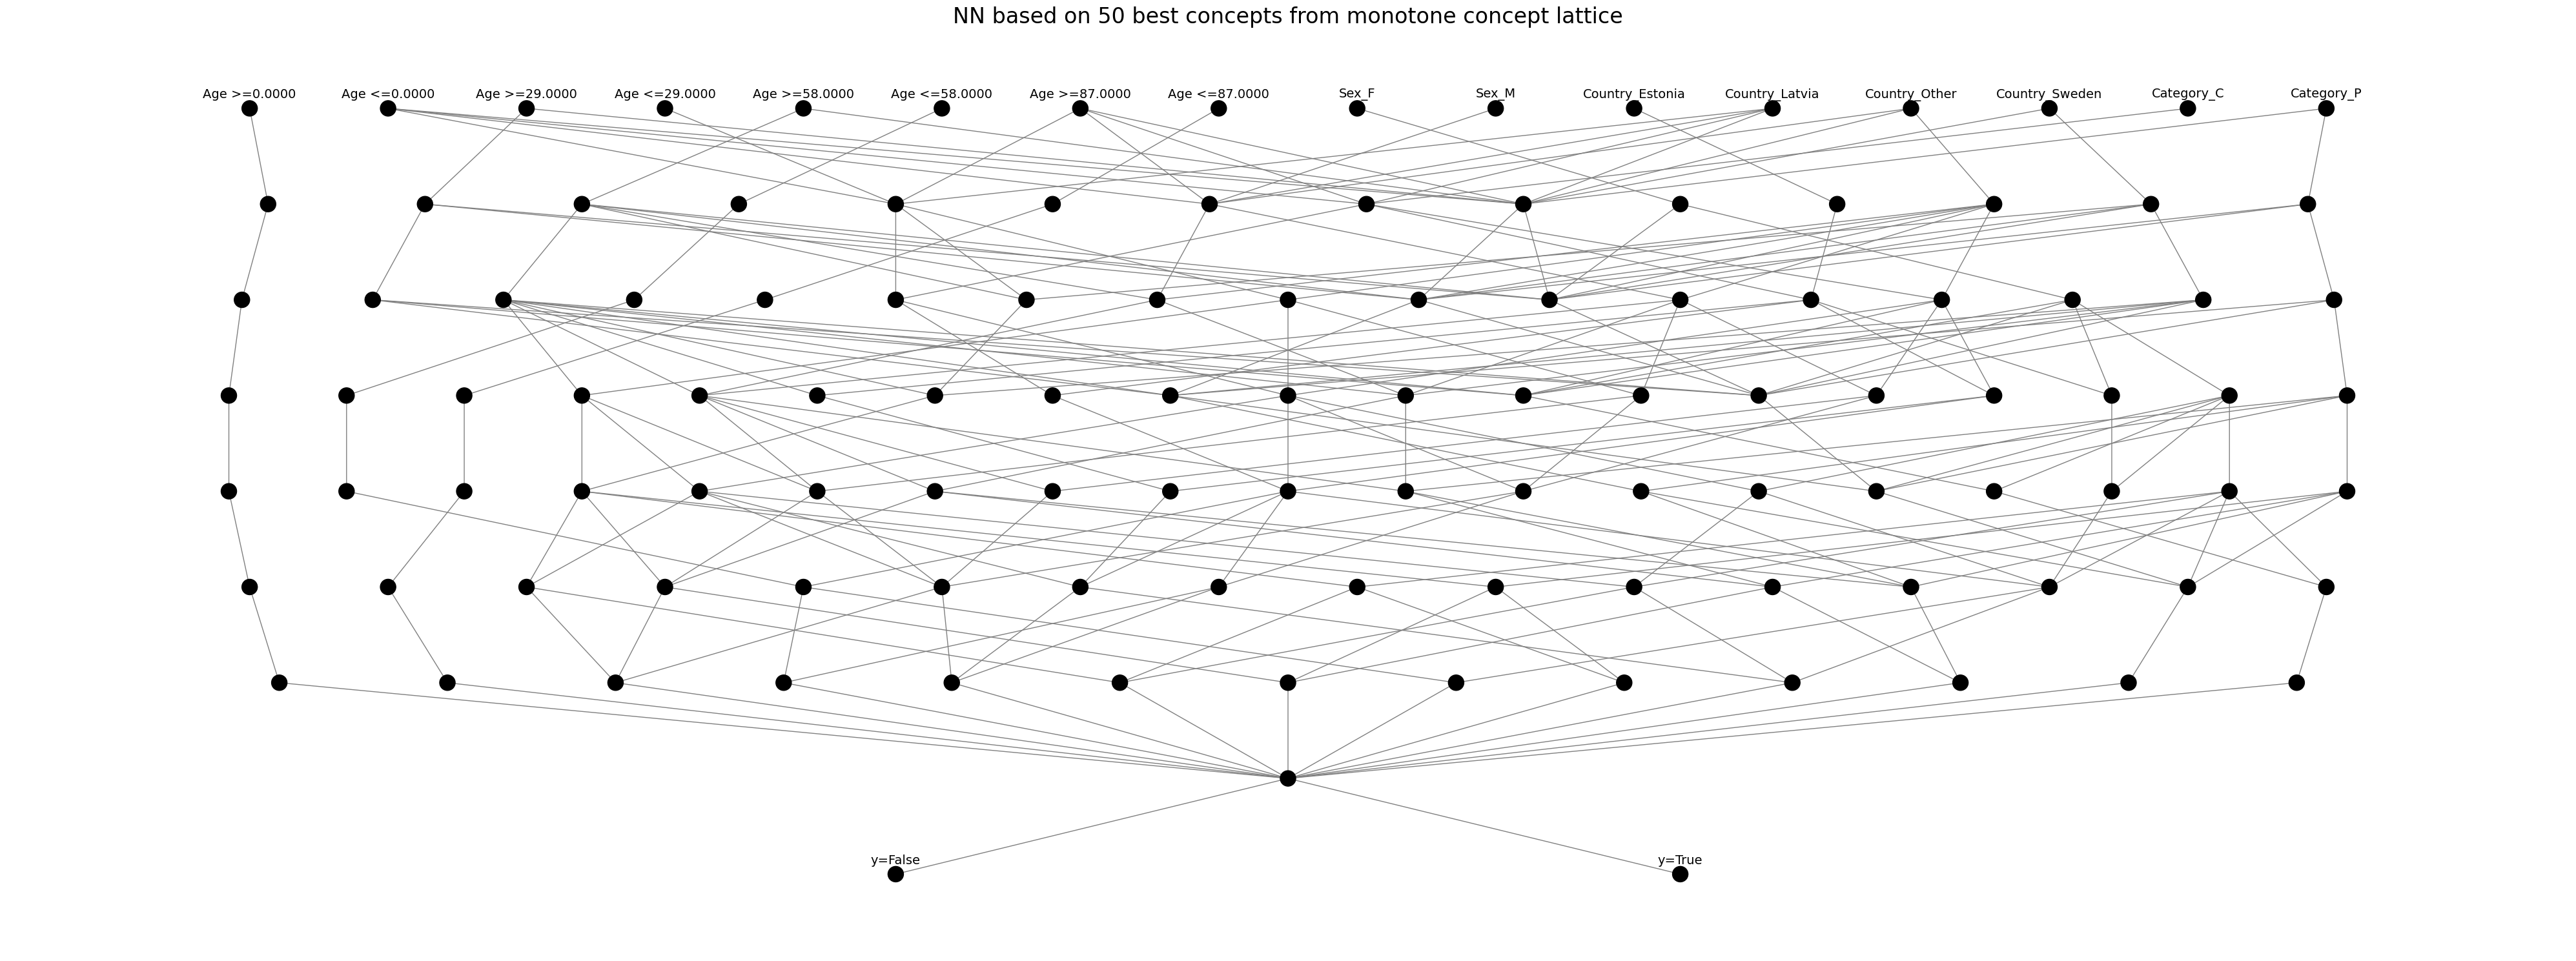

In [29]:
fig, ax = plt.subplots(figsize=(40, 15))

vis.draw_poset(
    cn.poset,
    ax=ax,
    edge_color="grey",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    node_color="black",
)

plt.title(
    f"NN based on {concepts_count} best concepts from monotone concept lattice",
    loc="center",
    size=24,
)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig(f"images/eesti/NN_architecture_{concepts_count}concepts.png")
plt.show()

In [30]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_trainNN)))
cn.fit(X_trainNN, y_trainNN, n_epochs=2500, nonlinearity=torch.nn.GELU)

In [31]:
y_predNN = cn.predict(X_testNN)

In [32]:
scores[f"NeuralFCA(concepts_count={concepts_count})"] = [
    f1_score(y_testNN, y_predNN),
    accuracy_score(y_testNN, y_predNN),
]
print(
    f"NeuralFCA(concepts_count={concepts_count}):\n{classification_report(y_testNN, y_predNN)}"
)

NeuralFCA(concepts_count=50):
              precision    recall  f1-score   support

       False       0.86      1.00      0.93       214
        True       0.00      0.00      0.00        34

    accuracy                           0.86       248
   macro avg       0.43      0.50      0.46       248
weighted avg       0.74      0.86      0.80       248



C:\Users\anaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [33]:
scores_frame = pd.DataFrame(
    scores.values(), index=scores.keys(), columns=["f1_score", "accuracy"]
)
scores_frame.head()

,f1_score,accuracy
GaussianNB(),0.363636,0.802419
RandomForestClassifier(random_state=42),0.230769,0.838710
"HistGradientBoostingClassifier(class_weight='balanced', random_state=42)",0.326923,0.717742
NeuralFCA(concepts_count=50),0.000000,0.862903


C:\Users\anaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:607.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


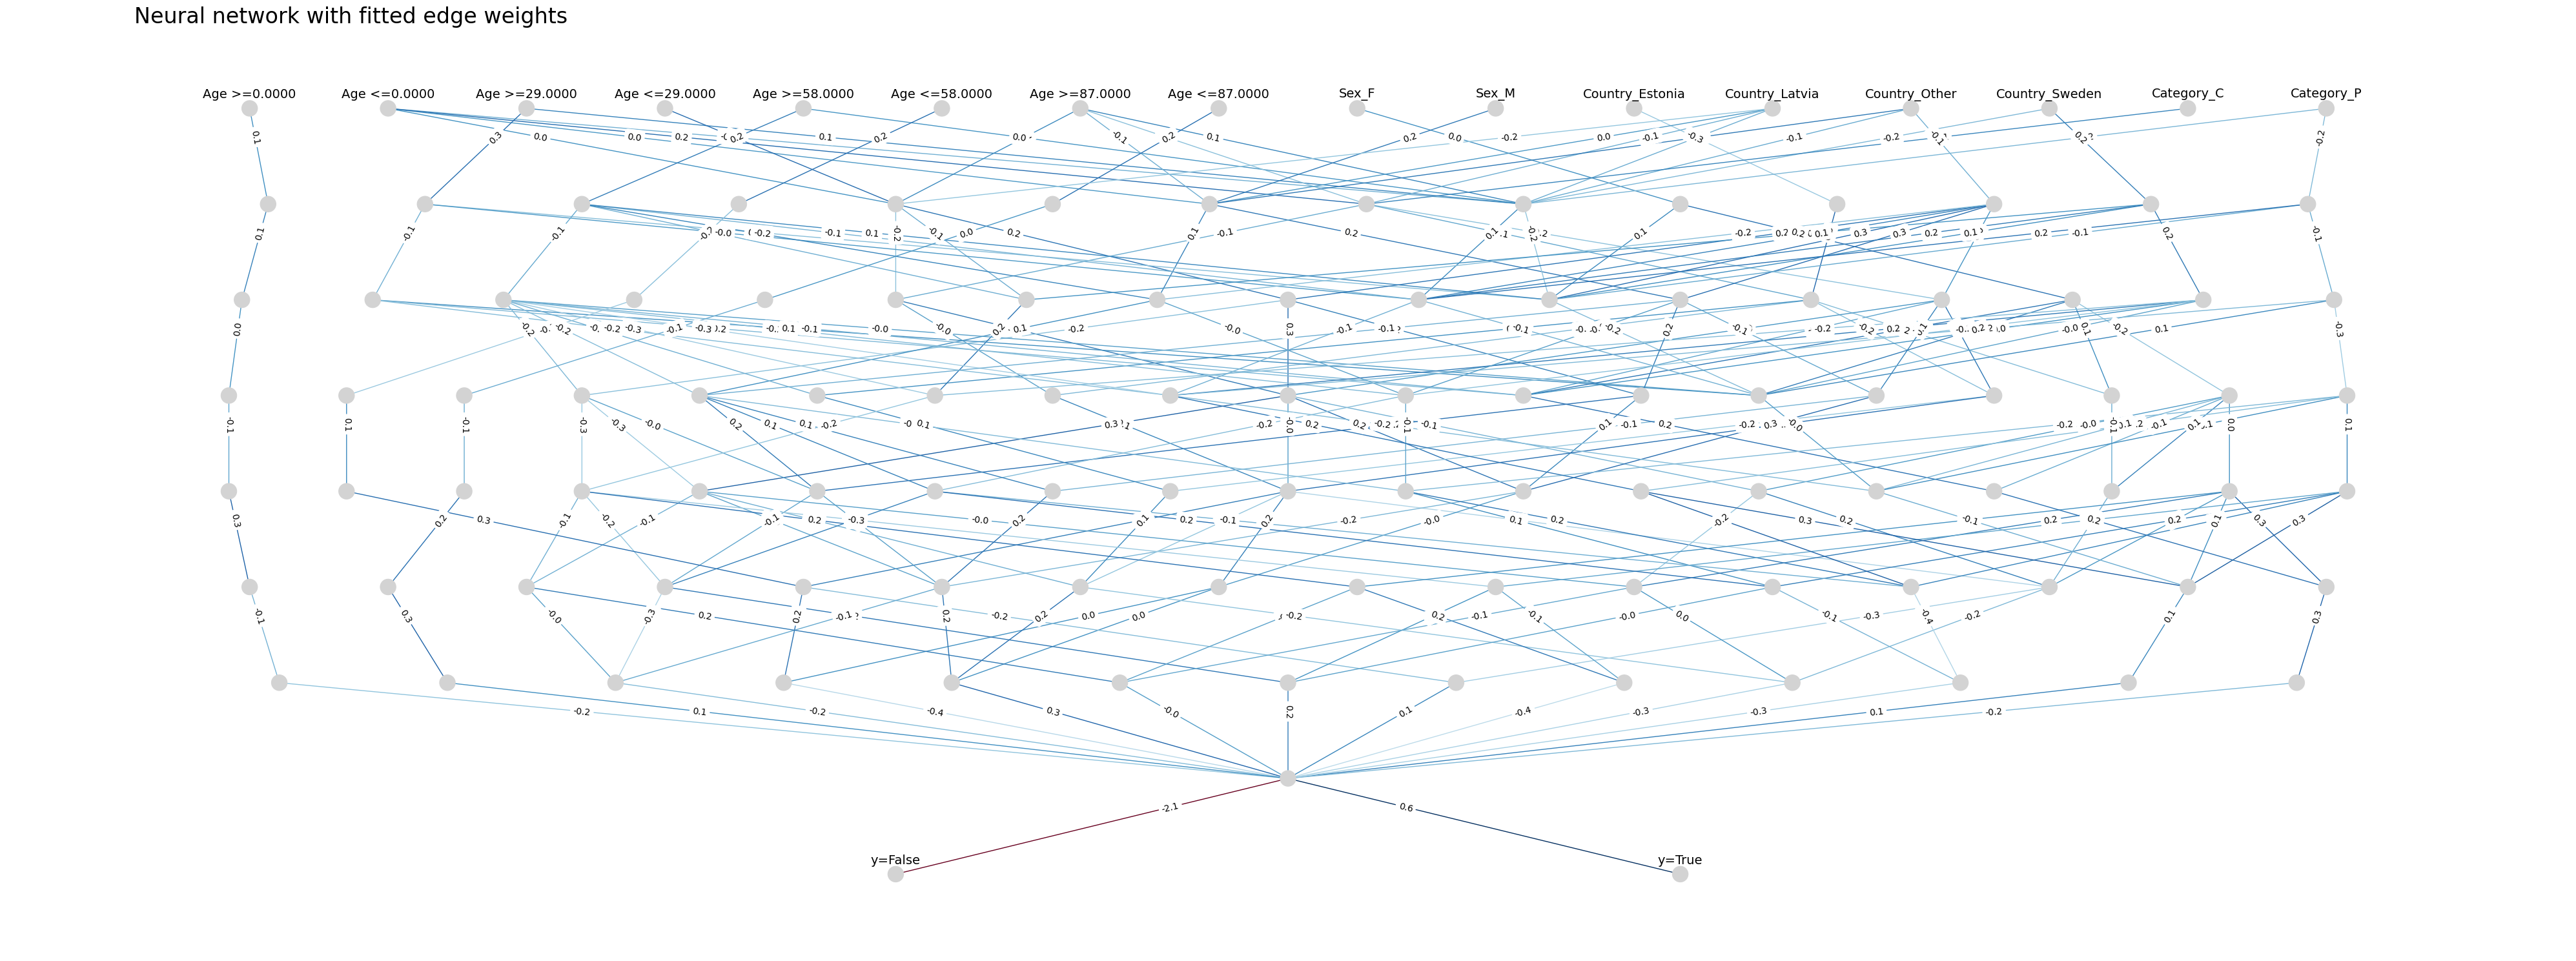

In [34]:
edge_weights = cn.edge_weights_from_network()

import networkx as nx

fig, ax = plt.subplots(figsize=(40, 15))

vis.draw_poset(
    cn.poset,
    ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig(f"images/eesti/NN_architecture_{concepts_count}concepts_fitted.png")
plt.show()